In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve as fftconv
import scipy
import skimage
import seaborn as sns
from matplotlib.patches import Circle
import visual_stimuli as vs

%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

In [2]:
# Load catcam data
video = skimage.io.ImageCollection('./movie01/Catt00*.tif')
fps = 25
pix_per_deg = 4.5
deg_to_px = lambda x: (x*pix_per_deg)//1
len(video) / fps

3.96

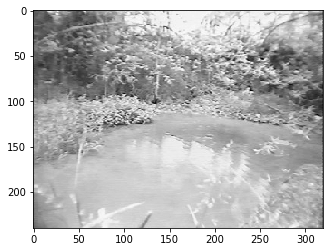

In [12]:
plt.imshow(video[0])  # 8-bit grayscale images (values go from 0 to 255)

In [4]:
video_n_frames = len(video)
video_width = video[0].shape[1]
video_height = video[1].shape[0]
video_width_deg = video_width / pix_per_deg
video_height_deg = video_height / pix_per_deg

video_center = video_width//2 + video_height//2*1j
video_center_pc = video_center / pix_per_deg

In [5]:
# Easier to operate with polar coordinates. Center of image at 0+0j
def polarcoord_to_px(z):
    zz = (z + video_center_pc) 
    px_coord = (int(zz.imag * pix_per_deg), int(zz.real * pix_per_deg))
    return px_coord

In [6]:

class RGCMosaic(object):

    # Average values with 120 Hz    
    #    on_parasol_temporal =  np.array([ 0.00362741,  0.6760954,   0.9748577,  -0.28691507, -0.34827891, -0.25112261,
    #                            -0.13433759, -0.07633461, -0.04407623, -0.02870208, -0.02116934, -0.02537785,
    #                            -0.02029849, -0.02229286, -0.02441606])
    #    off_parasol_temporal = np.array([ 0.01258721,  0.98875861,  0.6138703,  -0.19450219, -0.33041286, -0.25506613,
    #                            -0.1537128,  -0.10708742, -0.06478729, -0.05226135, -0.02350272, -0.02401291,
    #                            -0.00418208, -0.00541839, -0.00495736])

    
    # With 25 Hz let's use this 
    on_parasol_temporal =  np.array([1.0, -0.3, 0.0])

    
    def __init__(self):
        self.rgc_list = []
    
    def add_rgc(self, params_dict): # z_center, sigma_center, sigma_surround, factor_surround
        self.rgc_list.append(params_dict)
        
    def create_spatial_filter(self, rgc_ix):
        rgc_params = self.rgc_list[rgc_ix]
        z_center = rgc_params['z_center']
        sigma_center = rgc_params['sigma_center']
        sigma_surround = rgc_params['sigma_surround']
        factor_surround = rgc_params['factor_surround']
        
        filter_height = video_height
        filter_width = video_width

        x, y = np.meshgrid(np.linspace(-video_width_deg/2, video_width_deg/2, filter_width), 
                           -np.linspace(-video_height_deg/2, video_height_deg/2, filter_height))  # Why minus?

        d = np.sqrt((x - z_center.real)**2 + (y - z_center.imag)**2)
        filter_center = np.exp(-( d**2 / ( 2.0 * sigma_center**2 ) ) )
        filter_surround = factor_surround * np.exp(-( d**2 / ( 2.0 * sigma_surround**2 ) ) )
        
        
        
        dog_filter = filter_center - filter_surround

        return dog_filter
    
    def create_spatiotemporal_filter(self, rgc_ix):
        temporal_filter = RGCMosaic.on_parasol_temporal
        spatial_filter = self.create_spatial_filter(rgc_ix)
        spatial_filter_1d = np.reshape(spatial_filter, (video_width*video_height, 1))
        
        spatiotemporal_filter = spatial_filter_1d * [temporal_filter]
        return spatiotemporal_filter
    
    def plot_mosaic(self, ax=None):
        n_rgcs = len(self.rgc_list)
        
        plt.figure()
        ax = plt.gca()
        for i in range(n_rgcs):
            z = self.rgc_list[i]['z_center']
            sigma = self.rgc_list[i]['sigma_center']
            plt.scatter(z.real, z.imag, marker='.', color='blue')
            rf_circle = Circle(xy = (z.real, z.imag), radius=sigma)
            rf_circle.set_facecolor('none')
            rf_circle.set_edgecolor('black')
            ax.add_artist(rf_circle)
        
        plt.title('RF centers with 1SD circle')
        plt.axis('equal')
        plt.xlim([-video_width_deg/2, video_width_deg/2])
        plt.ylim([-video_height_deg/2, video_height_deg/2])
        
    def convolve(self, stim_video, rgc_ix, nonlinearity=np.exp):
        filter_kernel = self.create_spatiotemporal_filter(rgc_ix)
        stim_video_1d = np.reshape(stim_video, (video_n_frames, video_height*video_width))
        filtered_stim = fftconv(stim_video_1d, filter_kernel.T, mode='valid') / (video_height*video_width)
        return nonlinearity(filtered_stim)
    

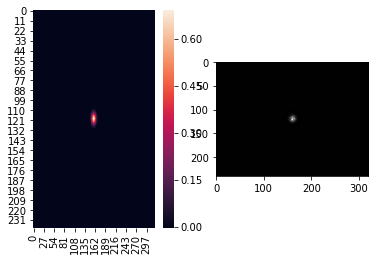

In [7]:
# Let's create a ganglion cell and see how the world looks from its viewpoint
mosaic = RGCMosaic()
mosaic.add_rgc({'z_center': 0+0j, 'sigma_center': 1.0, 'sigma_surround': 1.2, 'factor_surround': 0.3})
great_filter = mosaic.create_spatial_filter(0)

fig, ax = plt.subplots(1,2)
sns.heatmap(great_filter, ax=ax[0])

convolved_cat = video[7] * great_filter
ax[1].imshow(convolved_cat)
# TODO - lay out the figs nicely

Setting the following attributes:

pattern : sine_grating
temporal_frequency : 3
duration_seconds : 5
fps : 25
orientation : 0
image_width : 320
image_height : 240
Spatial_frequency missing, setting to 1
(76800, 3)
(125, 76800)


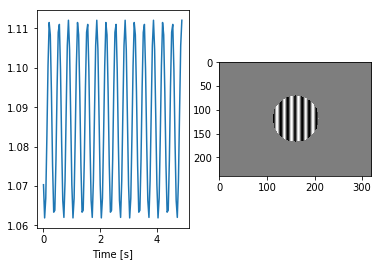

In [8]:
# Let's see if the ganglion cell can track a sine grating
video_grating = vs.ConstructStimulus(pattern='sine_grating', temporal_frequency=3, duration_seconds=5, fps=25, orientation=0, image_width=320, image_height=240)
grating_frames = video_grating.frames.transpose(2,0,1)
video_n_frames = len(grating_frames)
rgc_vm = mosaic.convolve(grating_frames, 0)

fig, ax = plt.subplots(1,2)
ax[0].plot(np.arange(0, len(rgc_vm))/fps, rgc_vm)
ax[0].set_xlabel('Time [s]')

ax[1].imshow(grating_frames[4,:,:])
# TODO - lay out the figs nicely

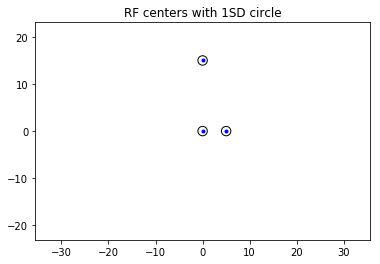

In [9]:
# Let's create some more ganglion cells
mosaic.add_rgc({'z_center': 5.0+0j, 'sigma_center': 1.0, 'sigma_surround': 1.2, 'factor_surround': 0.3})
mosaic.add_rgc({'z_center': 0+15.0j, 'sigma_center': 1.0, 'sigma_surround': 1.2, 'factor_surround': 0.3})
mosaic.plot_mosaic()

# Why's the center marker not in the center? 

(76800, 3)
(99, 76800)
(76800, 3)
(99, 76800)
(76800, 3)
(99, 76800)


Text(0.5, 0, 'Time [s]')

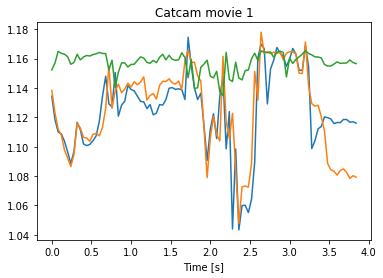

In [11]:
# Let's have a look at the catcam video
video_n_frames = len(video)
rgc_vm0 = mosaic.convolve(video, 0)
rgc_vm1 = mosaic.convolve(video, 1)
rgc_vm2 = mosaic.convolve(video, 2)
plt.plot(np.arange(0, len(rgc_vm0))/fps, rgc_vm0)
plt.plot(np.arange(0, len(rgc_vm1))/fps, rgc_vm1)
plt.plot(np.arange(0, len(rgc_vm2))/fps, rgc_vm2)
plt.title('Catcam movie 1')
plt.xlabel('Time [s]')